In [1]:
#import libraries
import os
import zipfile
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import keras
import cv2
%matplotlib inline

#import K-Means
from sklearn.cluster import KMeans
# important metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
np.random.seed(42)

# Data Processing

In [3]:
zip_files = glob.glob('/kaggle/input/dogs-vs-cats/*.zip')

print('{} files found in the input directory'.format(str(len(zip_files))) +'\n')
for file in zip_files:
    with zipfile.ZipFile(file, 'r') as Z:
        Z.extractall('data')
    print ('{} is extracted'.format(file.split('/')[-1]) + '\n')
      
print('Extraction is completed' + '\n')

2 files found in the input directory

test1.zip is extracted

train.zip is extracted

Extraction is completed



In [4]:
# os.listdir("./data/train")

In [5]:
data = []
label = []
path = "./data/train/"
c = 0
d = 0
IMG_SIZE = 32

for file in os.listdir(path):
    img=cv2.imread(path+file)
    img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    img=img.astype('float32')
    
    if file[:3]=='cat':
        if c==200: continue
        c+=1
        label.append("cat")
    else:
        if d==200: continue
        d+=1
        label.append("dog")
    
    data.append(img)
data = np.array(data)

In [6]:
# converting label cat to 0 and dog to 1
data_label = []
for i in label:
    if i=="cat": data_label.append(0)
    else: data_label.append(1)
data_label = np.array(data_label)

In [7]:
# Data Normalization

# Normalization
data = data/255.0
    
# k-means accept data with less than 3 dimensions
reshaped_data = data.reshape(len(data),-1)
reshaped_data.shape

(400, 3072)

# Standard K-Means for image classification

In [8]:
# Applying K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(reshaped_data)
kmeans.cluster_centers_.shape

(2, 3072)

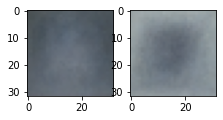

In [9]:
# This is how our centroids look like
kmeans.cluster_centers_ = kmeans.cluster_centers_*255
plt.figure(figsize = (10,9))
bottom = 0.35
for i in range(2):
    plt.subplots_adjust(bottom)
    plt.subplot(4,4,i+1)
    plt.imshow(kmeans.cluster_centers_[i].astype(int).reshape(32,32,3))

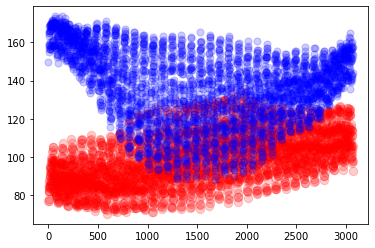

In [10]:
# Scatter Plot for both the centroids
x_data = [i for i in range(3072)]
plt.scatter(x_data,kmeans.cluster_centers_[0], color = 'red',alpha=0.2,s=70)
plt.scatter(x_data,kmeans.cluster_centers_[1] , color = 'blue',alpha=0.2,s=50)

In [11]:
# Since K-Means Does not know about our labels we have to change labels of k-means according to our usage

# mapping labels from cluster to original labels
def get_reference_dict(clusters,data_label):
    reference_label = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(clusters))):
        index = np.where(clusters == i,1,0)
        num = np.bincount(data_label[index==1]).argmax()
        reference_label[i] = num
    return reference_label

# Mapping predictions to original labels
def get_labels(clusters,refernce_labels):
    temp_labels = np.random.rand(len(clusters))
    for i in range(len(clusters)):
        temp_labels[i] = reference_labels[clusters[i]]
    return temp_labels

In [12]:
reference_labels = get_reference_dict(clusters,data_label)
predicted_labels = get_labels(clusters,reference_labels)

In [13]:
# Accuracy Score for right predictions
print(accuracy_score(predicted_labels,data_label))

0.505


Text(0.5, 15.0, 'predicted label')

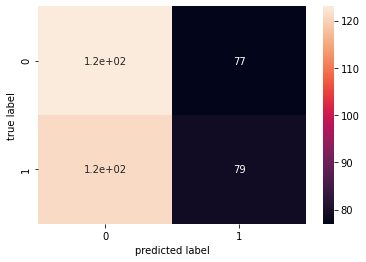

In [14]:
mat = confusion_matrix(data_label,predicted_labels)
sns.heatmap(mat, annot=True)
plt.ylabel('true label')
plt.xlabel('predicted label')

# Elbow Method: Find good value of K

Accuracy for k = 2:  0.505
Accuracy for k = 16:  0.5925
Accuracy for k = 64:  0.66
Accuracy for k = 100:  0.7175
Accuracy for k = 256:  0.865


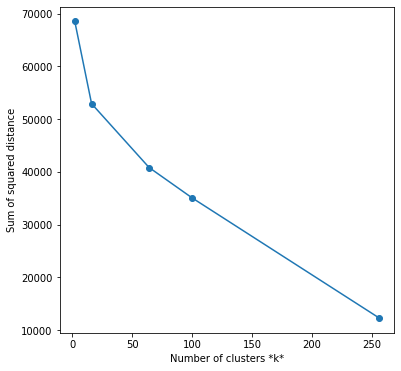

In [15]:
# elbow method
# squared distance
sse = []
list_k = [2,16,64,100,256]

for k in list_k:
    km = KMeans(n_clusters=k)
    clusters = km.fit_predict(reshaped_data)
    sse.append(km.inertia_)
    
    reference_labels = get_reference_dict(clusters,data_label)
    predicted_labels = get_labels(clusters,reference_labels)
    
    print(f"Accuracy for k = {k}: ", accuracy_score(predicted_labels,data_label))

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

# Transfer Learning

In [16]:
# Libraries
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image

In [17]:
# Extract features from resnet50
def extract_vector(data_holder):
    resnet_feature_list = []

    for im in data_holder:
        im = image.img_to_array(im) 
#         print("dimensions of im: ", im.shape)
        img = preprocess_input(np.expand_dims(im.copy(), axis=0))
#         print("dimensions of img: ", img.shape)
        resnet_feature = model.predict(img)
        resnet_feature_np = np.array(resnet_feature)
#         print("dimensions of resnet_feature_np: ", resnet_feature_np.shape)
        resnet_feature_list.append(resnet_feature_np.flatten())

    return np.array(resnet_feature_list)

Output <br>
dimensions of im:  (32, 32, 3)<br>
dimensions of img:  (1, 32, 32, 3)<br>
dimensions of resnet_feature_np:  (1, 1, 1, 2048)<br>

In [18]:
# IMG_SIZE = 32
model =   keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE,3))

94773248/94765736 [==============================] - 1s 0us/step


In [19]:
# Extract vectors and apply kmeans
array = extract_vector(data)
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(array)

In [20]:
reference_labels = get_reference_dict(clusters,data_label)
predicted_labels = get_labels(clusters,reference_labels)

In [21]:
from sklearn.metrics import accuracy_score
print(accuracy_score(predicted_labels,data_label))

0.5225


Text(0.5, 15.0, 'predicted label')

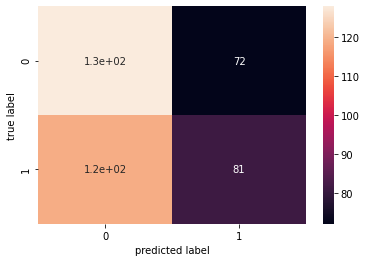

In [22]:
mat = confusion_matrix(data_label,predicted_labels )
sns.heatmap(mat, annot=True)
plt.ylabel('true label')
plt.xlabel('predicted label')